In [1]:
import numpy as np
import matplotlib.cm as cm
from matplotlib import ticker
import math
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib
#import mpl_scatter_density
import xarray as xr
import dask
from sklearn.neighbors import KDTree
import netCDF4
from metpy import calc
from metpy.units import units

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
from IPython.display import HTML
from matplotlib import animation
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde
import skimage
import plotly.graph_objects as go

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.cluster import KMeans

import matplotlib
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from statistics import mode
from matplotlib import transforms
import netCDF4

import os
import moviepy.video.io.ImageSequenceClip
from IPython.display import Video

In [2]:
path = "/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-20-00000.nc"
extra_variables = xr.open_dataset(path)
ha = extra_variables.hyai.values
hb = extra_variables.hybi.values
PS = 1e5
Pressures_real = PS*ha+PS*hb

In [3]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [4]:
others = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
levs = np.array(others.variables['lev'])
lons = np.array(others.variables['lon'])
new = np.flip(levs)
crms = np.arange(1,129,1)
Xs, Zs = np.meshgrid(crms, new)

In [5]:
path_to_file = '/DFS-L/DATA/pritchard/gmooers/Raw_Data_Storage/MAPS/SPCAM/100_Days/New_SPCAM5/archive/TimestepOutput_Neuralnet_SPCAM_216/atm/hist/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc'
extra_variables = xr.open_dataset(path_to_file)
latitudes = np.squeeze(extra_variables.LAT_20s_to_20n.values)
longitudes = np.squeeze(extra_variables.LON_0e_to_360e.values)
new_lons, new_lats = np.meshgrid(longitudes, latitudes)

In [ ]:
#Test_Images = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/Unscaled_Big_Alt_Multi_Sim_Randomized_Space_Time_W_Test.npy')
Test_Images_4K = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/4K_Big_Multi_Sim_Randomized_Space_Time_W_Test.npy')

In [14]:
lat_test = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/Big_Alt_Multi_Sim_Randomized_Space_Time_Lat_Test.npy', mmap_mode="r")
lon_test = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/Big_Alt_Multi_Sim_Randomized_Space_Time_Lon_Test.npy', mmap_mode="r")

lat_test_4K = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/4K_Big_Multi_Sim_Randomized_Space_Time_Lat_Test.npy', mmap_mode="r")
lon_test_4K = np.load('/DFS-L/DATA/pritchard/gmooers/Finished_Classic_Data/Big_Randomized_Trackable/4K_Big_Multi_Sim_Randomized_Space_Time_Lon_Test.npy', mmap_mode="r")

In [15]:
SPCAM5_3100_Recon_0 = np.load("Compressed_Data/0K_Recon_Diffs.npy")
SPCAM5_3100_Recon_4 = np.load("Compressed_Data/4K_Recon_Diffs.npy")
SPCAM5_3100_Reconstruction_Error_Diffs = np.abs(SPCAM5_3100_Recon_4 + SPCAM5_3100_Recon_0)

# Calculate the W Sums

In [ ]:
#sum_0K = np.sum(np.sum(np.abs(np.abs(Test_Images)), axis=1), axis=1)
sum_4K = np.sum(np.sum(np.abs(np.abs(Test_Images_4K)), axis=1), axis=1)

# Calculate the Turbulent Length Scales

In [ ]:
#ww_test_0K = np.empty(Test_Images.shape)
ww_test_4K = np.empty(Test_Images_4K.shape)
for i in range(len(Test_Images_4K)):
    #ww_test_0K[i,:,:] = (Test_Images[i,:,:] - np.nanmean(np.squeeze(Test_Images[i,:,:]),axis=1)[:,None])**2
    ww_test_4K[i,:,:] = (Test_Images_4K[i,:,:] - np.nanmean(np.squeeze(Test_Images_4K[i,:,:]),axis=1)[:,None])**2

In [ ]:
#ww_test_profile_0K = np.sum(ww_test_0K, axis=1)
ww_test_profile_4K = np.sum(ww_test_4K, axis=1)

In [6]:
def spectrum_gen(h, dx):
    nx = len(h)

    # Get half the length of the series to avoid redudant information
    npositive = nx//2
    pslice = slice(1, npositive)

    # Get frequencies
    freqs = np.fft.fftfreq(nx, d=dx)[pslice] 

    # Perform the fft 
    ft = np.fft.fft(h)[pslice]

    # Remove imaginary componant of the fft and square
    psraw = np.conjugate(ft) *ft

    # Double to account for the negative half that was removed above
    psraw *= 2.0

    # Normalization for the power spectrum
    psraw /= nx**2

    # Go from the Power Spectrum to Power Density
    psdraw = psraw * dx * nx

    return freqs, psraw, psdraw

In [7]:
def EQ_1_spatial_fft(w_array):
    spatial_labels = np.empty(shape=(len(w_array)))
    for i in range(len(w_array)):
        W_freqs, W_psraw, W_psdraw = spectrum_gen(w_array[i,:], 1)
        L = np.sum(W_psdraw*(1/W_freqs))/np.sum(W_psdraw)
        spatial_labels[i] = L
    
    return spatial_labels

#EQ_1_ww_test_profile_0K  = EQ_1_spatial_fft(ww_test_profile_0K)
EQ_1_ww_test_profile_4K = EQ_1_spatial_fft(ww_test_profile_4K)

NameError: name 'ww_test_profile_4K' is not defined

# Geographically Condition

In [ ]:
lat_keys = np.arange(0,22,1)
lat_values = latitudes
lon_keys = np.arange(0,144,1)
lon_values = longitudes

lat_dic = dict(zip(lat_values, lat_keys))
lon_dic = dict(zip(lon_values, lon_keys))

In [ ]:
#sum_map_0K = np.zeros(shape=(22,144))
#sum_map_counter_0K = np.zeros(shape=(22,144))
sum_map_4K = np.zeros(shape=(22,144))
sum_map_counter_4K = np.zeros(shape=(22,144))

#tls_map_0K = np.zeros(shape=(22,144))
#tls_map_counter_0K = np.zeros(shape=(22,144))
tls_map_4K = np.zeros(shape=(22,144))
tls_map_counter_4K = np.zeros(shape=(22,144))

In [ ]:
for i in range(len(sum_4K)):
    #sum_map_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = sum_map_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + sum_0K[i]
    #sum_map_counter_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = sum_map_counter_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    sum_map_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] = sum_map_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] + sum_4K[i]
    sum_map_counter_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] = sum_map_counter_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] + 1
    
    #tls_map_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = tls_map_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + EQ_1_ww_test_profile_0K[i]
    #tls_map_counter_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] = tls_map_counter_0K[lat_dic[lat_test[i]],lon_dic[lon_test[i]]] + 1
    tls_map_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] = tls_map_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] + EQ_1_ww_test_profile_4K[i]
    tls_map_counter_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] = tls_map_counter_4K[lat_dic[lat_test_4K[i]],lon_dic[lon_test_4K[i]]] + 1
    

In [ ]:
for i in range(len(sum_map_4K)):
    for j in range(len(sum_map_4K[i])):
        #sum_map_0K[i,j] = sum_map_0K[i,j]/sum_map_counter_0K[i,j]
        sum_map_4K[i,j] = sum_map_4K[i,j]/sum_map_counter_4K[i,j]
        #tls_map_0K[i,j] = tls_map_0K[i,j]/tls_map_counter_0K[i,j]
        tls_map_4K[i,j] = tls_map_4K[i,j]/tls_map_counter_4K[i,j]

# Make the plot

In [9]:
#np.save("Compressed_Data/SI_0K_W_Sum.npy", sum_map_0K)
#np.save("Compressed_Data/SI_0K_W_TLS.npy", tls_map_0K)
#np.save("Compressed_Data/SI_4K_W_Sum.npy", sum_map_4K)
#np.save("Compressed_Data/SI_4K_W_TLS.npy", tls_map_4K)

In [10]:
sum_map_0K = np.load("Compressed_Data/SI_0K_W_Sum.npy")
tls_map_0K = np.load("Compressed_Data/SI_0K_W_TLS.npy")
sum_map_4K = np.load("Compressed_Data/SI_4K_W_Sum.npy")
tls_map_4K = np.load("Compressed_Data/SI_4K_W_TLS.npy")

In [11]:
sum_map_diffs = sum_map_4K - sum_map_0K
tls_map_diffs = tls_map_4K - tls_map_0K

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


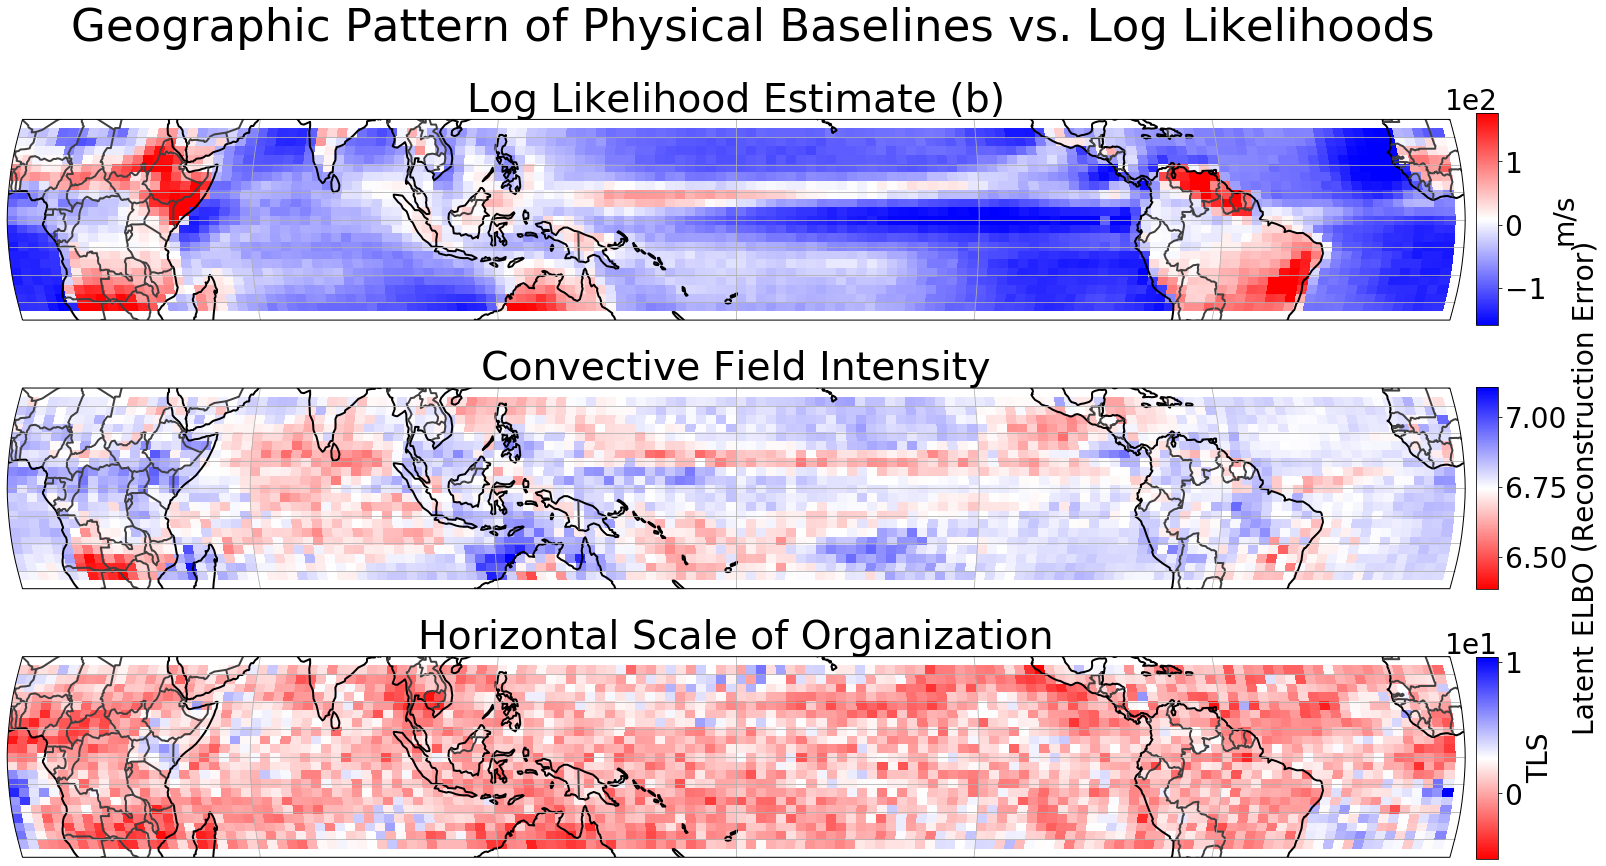

In [16]:
fig, ax = plt.subplots(3,1,figsize=(30,14),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

cp = ax[0].pcolormesh(new_lons, new_lats, SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024),cmap="bwr_r", vmin =np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 1), vmax = np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 99), transform=ccrs.PlateCarree())
ax[0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[0].set_title("Log Likelihood Estimate (b)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.403, 0.01, 0.20])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='Latent ELBO (Reconstruction Error)', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

cp = ax[1].pcolormesh(new_lons, new_lats, sum_map_diffs,cmap="bwr", transform=ccrs.PlateCarree())
ax[1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[1].set_title("Convective Field Intensity", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.665, 0.01, 0.21])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='m/s', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

cp = ax[2].pcolormesh(new_lons, new_lats, tls_map_diffs, cmap="bwr_r", transform=ccrs.PlateCarree())
ax[2].coastlines(linewidth=2.0,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[2].set_title("Horizontal Scale of Organization", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.135, 0.01, 0.20])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='TLS', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

plt.suptitle("Geographic Pattern of Physical Baselines vs. Log Likelihoods", y = 0.98, x=0.47, fontsize=fz*2.0)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.png", bbox_inches='tight',pad_inches = 0)
#plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.pdf", bbox_inches='tight',pad_inches = 0)

findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXGeneral'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXNonUnicode'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeOneSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeTwoSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeThreeSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFourSym'] not found. Falling back to DejaVu Sans.
findfont: Font family ['STIXSizeFiveSym'] not found. Falling back to DejaVu Sans.


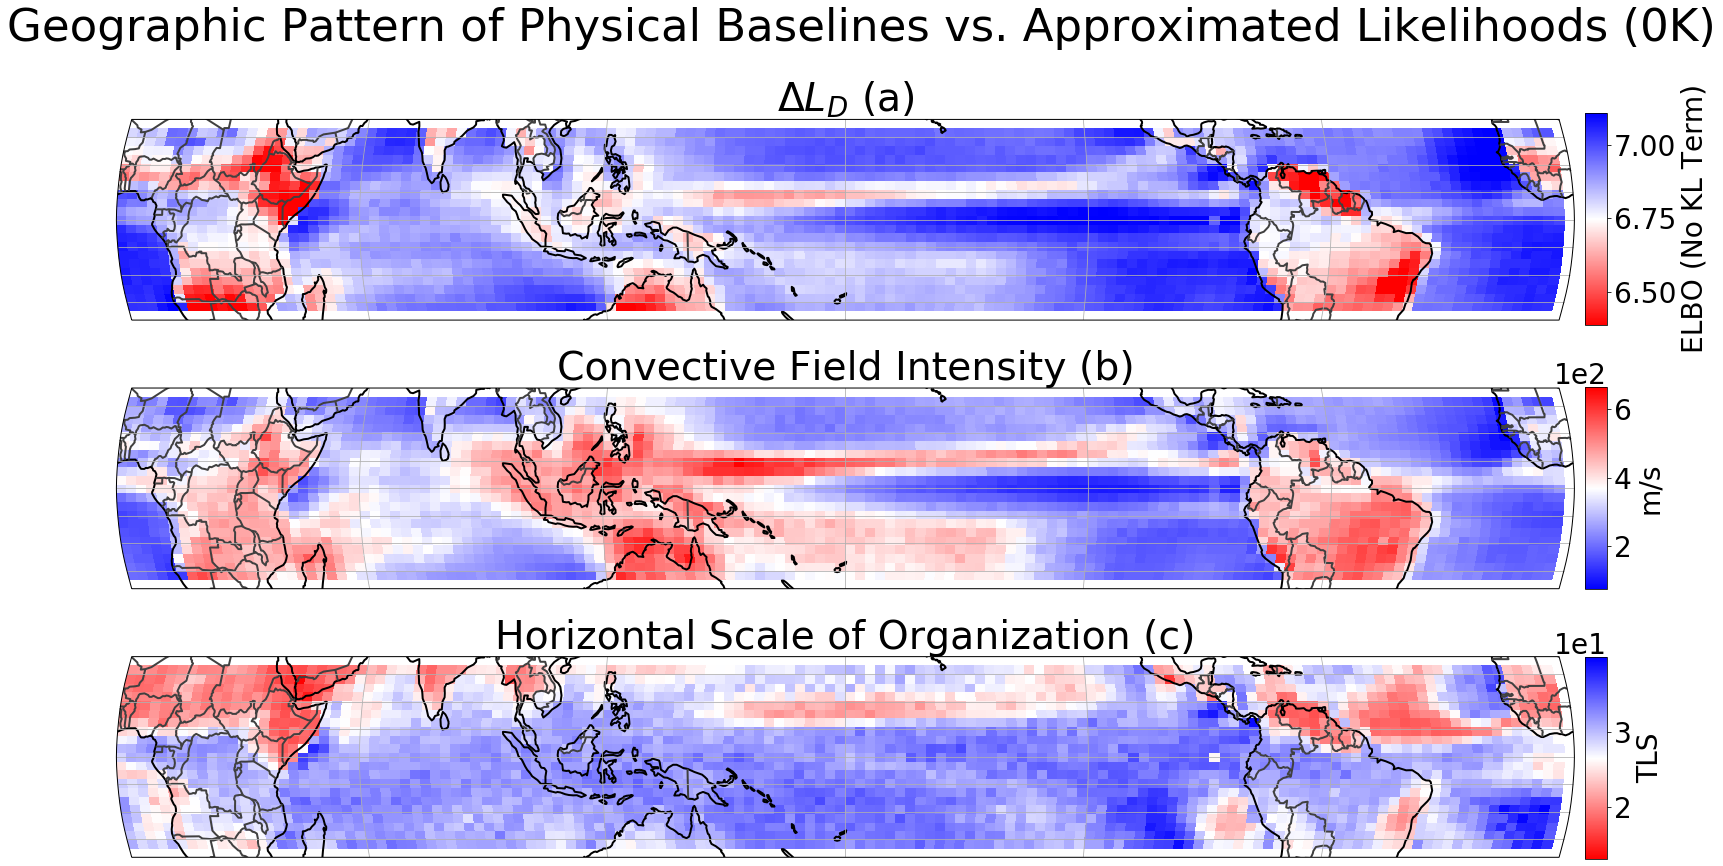

In [17]:
fig, ax = plt.subplots(3,1,figsize=(30,14),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

cp = ax[0].pcolormesh(new_lons, new_lats, SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024),cmap="bwr_r", vmin =np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 1), vmax = np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 99), transform=ccrs.PlateCarree(), rasterized=True)
ax[0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[0].set_title("$\Delta {\mathit{L}}_D$ (a)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.665, 0.01, 0.21])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='ELBO (No KL Term)', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

cp = ax[1].pcolormesh(new_lons, new_lats, sum_map_0K,cmap="bwr", transform=ccrs.PlateCarree(), rasterized=True)
ax[1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[1].set_title("Convective Field Intensity (b)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.403, 0.01, 0.20])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='m/s', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

cp = ax[2].pcolormesh(new_lons, new_lats, tls_map_0K, cmap="bwr_r", transform=ccrs.PlateCarree(), rasterized=True)
ax[2].coastlines(linewidth=2.0,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[2].set_title("Horizontal Scale of Organization (c)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.135, 0.01, 0.20])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='TLS', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

plt.suptitle("Geographic Pattern of Physical Baselines vs. Approximated Likelihoods (0K)", y = 0.98, x=0.47, fontsize=fz*2.0)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
#plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.png", bbox_inches='tight',pad_inches = 0)
#plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.pdf", bbox_inches='tight',pad_inches = 0)

In [18]:
pearson_r, pearson_p = scipy.stats.pearsonr((SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024)).ravel(), sum_map_0K.ravel())
print("R^2 of Recon Error vs. Intensity:",pearson_r**2)
pearson_r, pearson_p = scipy.stats.pearsonr((SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024)).ravel(), tls_map_0K.ravel())
print("R^2 of Recon Error vs. TLS:",pearson_r**2)

R^2 of Recon Error vs. Intensity: 0.6870350500225133
R^2 of Recon Error vs. TLS: 0.095499755199804


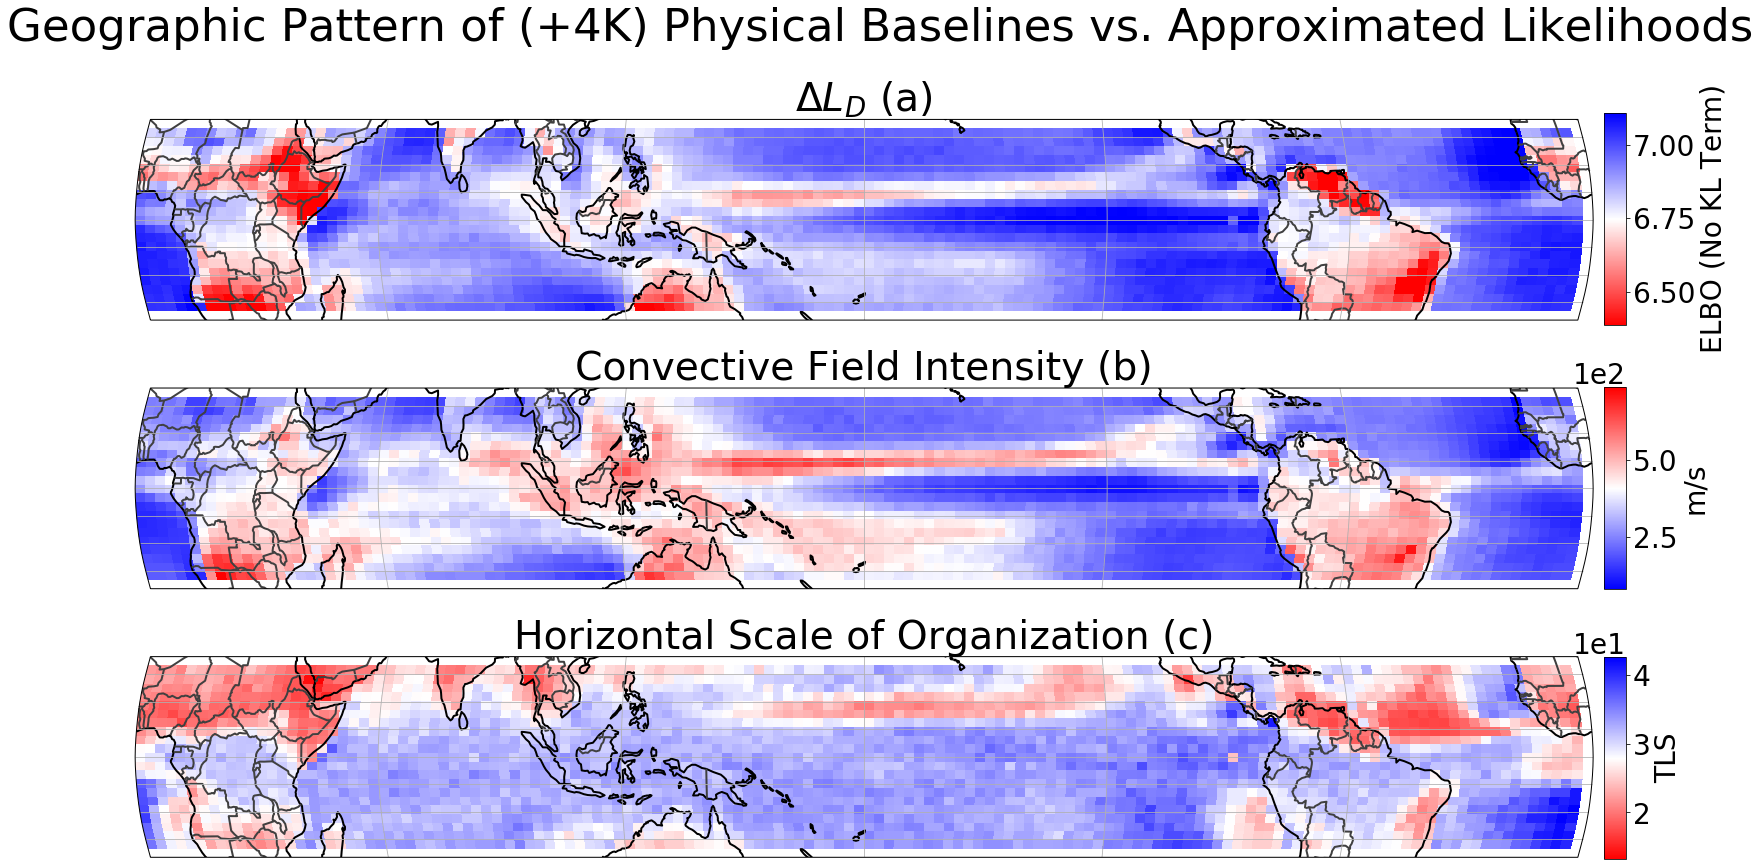

In [19]:
fig, ax = plt.subplots(3,1,figsize=(30,14),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})

cp = ax[0].pcolormesh(new_lons, new_lats, SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024),cmap="bwr_r", vmin =np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 1), vmax = np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 99), transform=ccrs.PlateCarree(), rasterized=True)
ax[0].coastlines(linewidth=2.0,edgecolor='0.25')
ax[0].gridlines()
ax[0].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[0].set_title(r"$\Delta {\mathit{L}}_D$ (a)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.665, 0.01, 0.21])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='ELBO (No KL Term)', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

cp = ax[1].pcolormesh(new_lons, new_lats, sum_map_4K,cmap="bwr", transform=ccrs.PlateCarree(), rasterized=True)
ax[1].coastlines(linewidth=2.0,edgecolor='0.25')
ax[1].gridlines()
ax[1].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[1].set_title("Convective Field Intensity (b)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.403, 0.01, 0.20])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='m/s', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

cp = ax[2].pcolormesh(new_lons, new_lats, tls_map_4K, cmap="bwr_r", transform=ccrs.PlateCarree(), rasterized=True)
ax[2].coastlines(linewidth=2.0,edgecolor='0.25')
ax[2].gridlines()
ax[2].add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax[2].set_title("Horizontal Scale of Organization (c)", fontsize=fz*1.75)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.135, 0.01, 0.20])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='TLS', fontsize=fz*1.25)
cbar.ax.tick_params(labelsize=fz*1.25) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.25)

plt.suptitle("Geographic Pattern of (+4K) Physical Baselines vs. Approximated Likelihoods", y = 0.98, x=0.47, fontsize=fz*2.0)
plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.pdf", bbox_inches='tight',pad_inches = 0)

In [20]:
pearson_r, pearson_p = scipy.stats.pearsonr((SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024)).ravel(), sum_map_4K.ravel())
print("R^2 of Recon Error vs. Intensity:",pearson_r**2)
pearson_r, pearson_p = scipy.stats.pearsonr((SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024)).ravel(), tls_map_4K.ravel())
print("R^2 of Recon Error vs. TLS:",pearson_r**2)

R^2 of Recon Error vs. Intensity: 0.686716453808239
R^2 of Recon Error vs. TLS: 0.13463620828523065


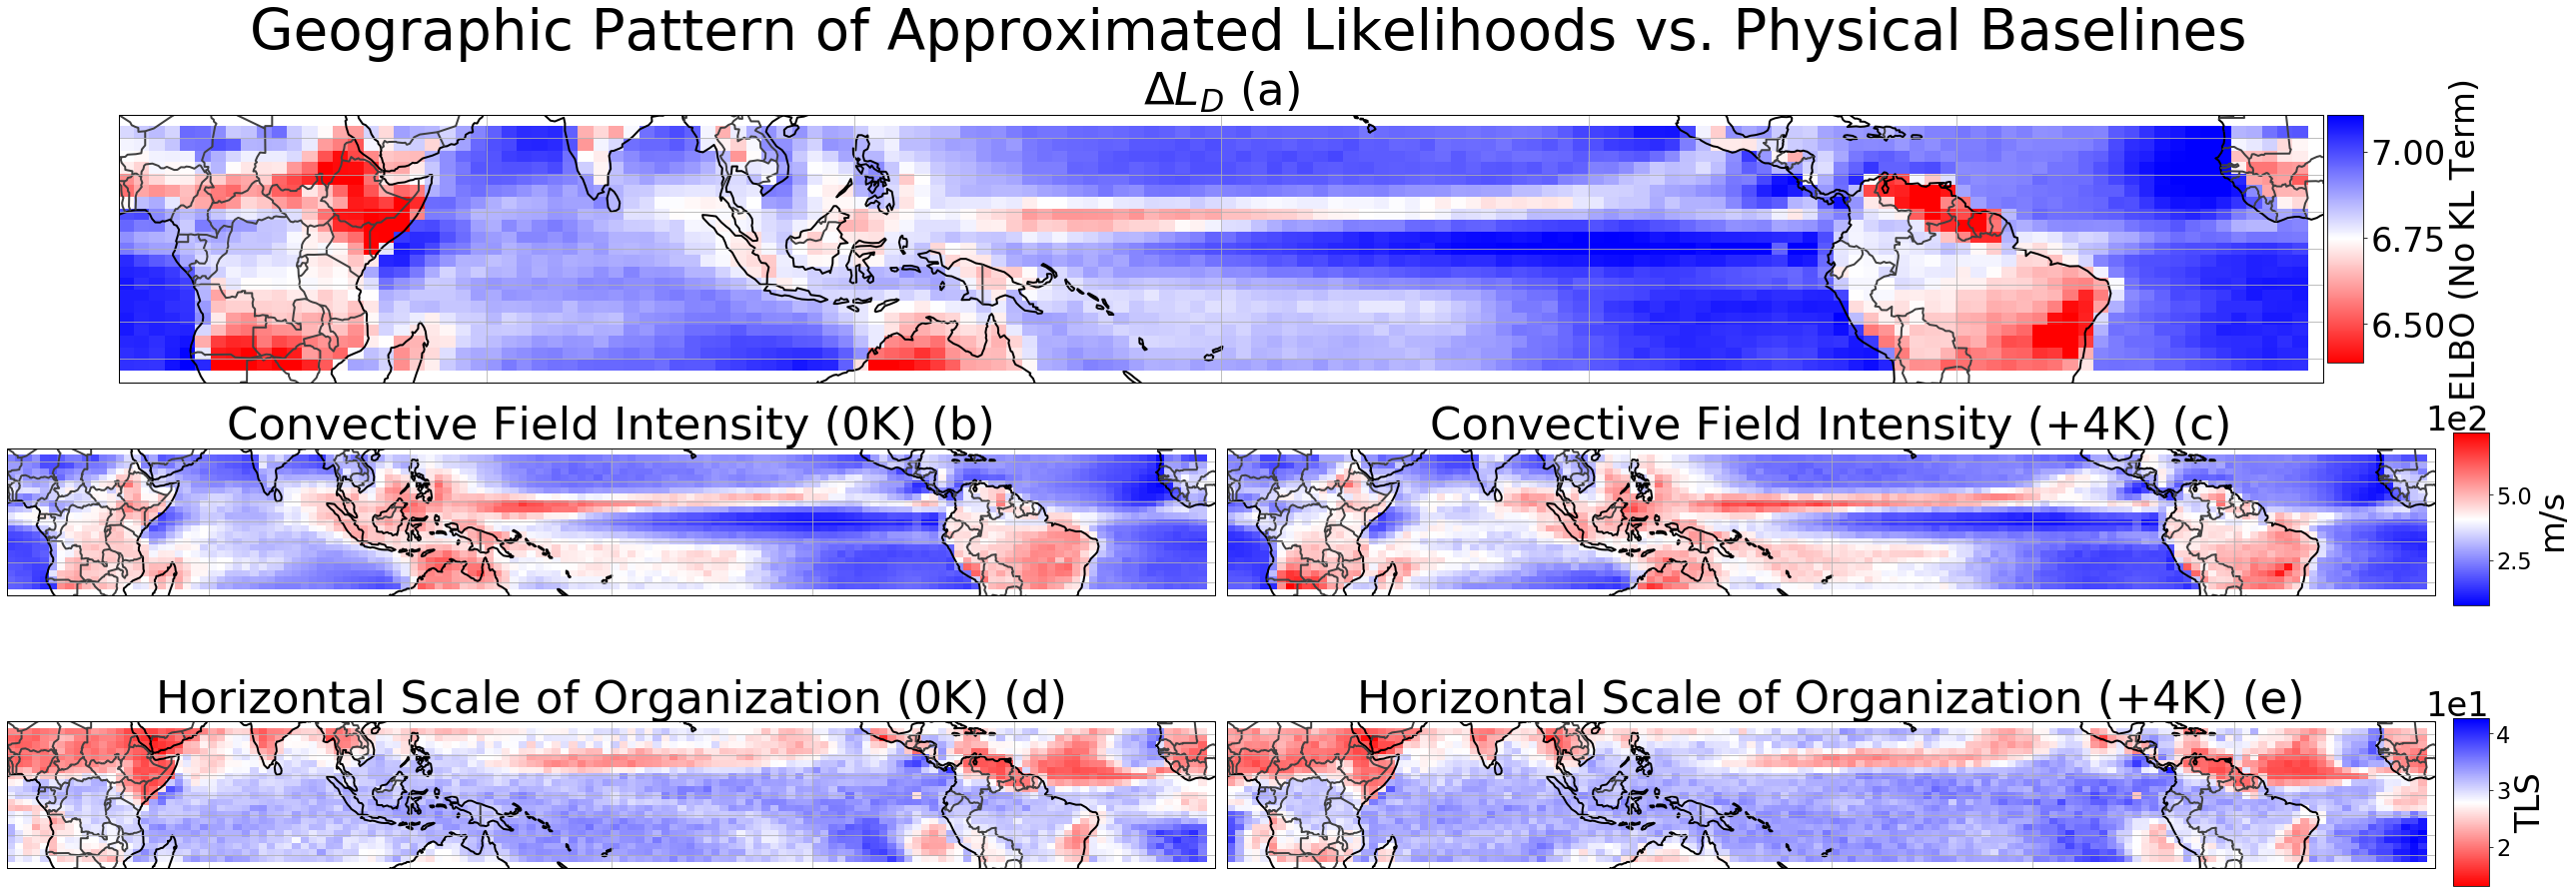

In [61]:
#fig, ax = plt.subplots(3,2,figsize=(40,10),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
fig, ax = plt.subplots(3,2,figsize=(50,15),subplot_kw={'projection':ccrs.Robinson(central_longitude=180)})
gs=GridSpec(3,2)

ax1=fig.add_subplot(gs[0,:],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax2=fig.add_subplot(gs[1,0],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax3=fig.add_subplot(gs[1,1],projection=ccrs.PlateCarree(central_longitude=180)) # First row, second column 
ax4=fig.add_subplot(gs[2,0],projection=ccrs.PlateCarree(central_longitude=180)) # First row, first column
ax5=fig.add_subplot(gs[2,1],projection=ccrs.PlateCarree(central_longitude=180)) # First row, second column 

cp = ax1.pcolormesh(new_lons, new_lats, SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024),cmap="bwr_r", vmin =np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 1), vmax = np.percentile(SPCAM5_3100_Reconstruction_Error_Diffs/(30.*128.*1024), 99), transform=ccrs.PlateCarree(), rasterized=True)
ax1.coastlines(linewidth=2.0,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax1.set_title("$\Delta {\mathit{L}}_D$ (a)", fontsize=fz*2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.77, 0.65, 0.01, 0.23])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='ELBO (No KL Term)', fontsize=fz*1.5)
cbar.ax.tick_params(labelsize=fz*1.5) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.5)

cp = ax2.pcolormesh(new_lons, new_lats, sum_map_0K,cmap="bwr", transform=ccrs.PlateCarree(), rasterized=True, vmin =np.min(sum_map_0K), vmax=np.max(sum_map_4K))
ax2.coastlines(linewidth=2.0,edgecolor='0.25')
ax2.gridlines()
ax2.add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax2.set_title("Convective Field Intensity (0K) (b)", fontsize=fz*2)

cp = ax3.pcolormesh(new_lons, new_lats, sum_map_4K,cmap="bwr", transform=ccrs.PlateCarree(), rasterized=True, vmin = np.min(sum_map_0K), vmax=np.max(sum_map_4K))
ax3.coastlines(linewidth=2.0,edgecolor='0.25')
ax3.gridlines()
ax3.add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax3.set_title("Convective Field Intensity (+4K) (c)", fontsize=fz*2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.425, 0.01, 0.16])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='m/s', fontsize=fz*1.5)
cbar.ax.tick_params(labelsize=fz) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.5)

vmin = min([np.min(tls_map_0K),np.min(tls_map_4K)])
vmax = max([np.max(tls_map_0K),np.max(tls_map_4K)])

cp = ax4.pcolormesh(new_lons, new_lats, tls_map_0K, cmap="bwr_r", transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax=vmax)
ax4.coastlines(linewidth=2.0,edgecolor='0.25')
ax4.gridlines()
ax4.add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax4.set_title("Horizontal Scale of Organization (0K) (d)", fontsize=fz*2)


cp = ax5.pcolormesh(new_lons, new_lats, tls_map_4K, cmap="bwr_r", transform=ccrs.PlateCarree(), rasterized=True, vmin=vmin, vmax=vmax)
ax5.coastlines(linewidth=2.0,edgecolor='0.25')
ax5.gridlines()
ax5.add_feature(cfeature.BORDERS,linewidth=2.0,edgecolor='0.25')
ax5.set_title("Horizontal Scale of Organization (+4K) (e)", fontsize=fz*2)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.165, 0.01, 0.155])
cbar = fig.colorbar(cp, cax=cbar_ax)
cbar.set_label(label='TLS', fontsize=fz*1.5)
cbar.ax.tick_params(labelsize=fz) 
cbar.formatter.set_powerlimits((0, 0))
cbar.ax.yaxis.get_offset_text().set(size=fz*1.5)

fig.delaxes(ax[0,0])
fig.delaxes(ax[0,1])
fig.delaxes(ax[1,0])
fig.delaxes(ax[1,1])
fig.delaxes(ax[2,0])
fig.delaxes(ax[2,1])

plt.suptitle("Geographic Pattern of Approximated Likelihoods vs. Physical Baselines", y = 0.98, x=0.47, fontsize=fz*2.5)
plt.subplots_adjust(wspace=0.01, hspace=0.02)
plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.png", bbox_inches='tight',pad_inches = 0)
plt.savefig("Figures/PNAS_SI_Geo_Map_TLS.pdf", bbox_inches='tight',pad_inches = 0)